# Kilian COLLET ####

# TP 2 ####

In [2]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn import svm, datasets, tree
from sklearn.metrics import accuracy_score, precision_score, fbeta_score, make_scorer, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
import re
from nltk.corpus import stopwords

2023-01-03 16:10:16.327370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-03 16:10:16.327497: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 16:10:16.423928: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-03 16:10:17.863418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-03 16:10:17.863630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [3]:
def run_classifiers(clfs, X, Y):
    kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
    scores = {"accuracy": "accuracy", "auc": "roc_auc", "precision": "precision"}
    for i in clfs:
        clf = clfs[i]
        cv_scores = cross_validate(clf, X, Y, cv = kf, scoring = scores)
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_scores["test_accuracy"]), np.std(cv_scores["test_accuracy"])))
        print("AUC for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_scores["test_auc"]), np.std(cv_scores["test_auc"])))
        print("Precision for {0} is: {1:.3f} +/- {2:.3f}".format(i, np.mean(cv_scores["test_precision"]), np.std(cv_scores["test_precision"])))
        print("Execution time for {0} is: {1:.3f} +/- {2:.3f}\n".format(i, np.mean(cv_scores["fit_time"]), np.std(cv_scores["fit_time"])))

In [4]:
clfs = {
     'RF': RandomForestClassifier(n_estimators=200, random_state=1),
     'KNN': KNeighborsClassifier(n_neighbors=5),
     'NBS': GaussianNB(),
     'CART': tree.DecisionTreeClassifier(random_state = 1),
     'ID3': tree.DecisionTreeClassifier(criterion = 'entropy',random_state = 1),
     'DS': tree.DecisionTreeClassifier(max_depth=1, random_state = 1),
     'MLP': MLPClassifier(hidden_layer_sizes=(50, 10), random_state=1),
     'BC': BaggingClassifier(n_estimators=200, random_state=1),
     'ADA': AdaBoostClassifier(n_estimators=200, random_state=1),
     'SVC': SVC(),
}

# II. Apprentissage supervisé : Données hétérogènes ####

In [5]:
# Question 1

In [6]:
data = pd.read_csv('./credit.data',sep='\t', header=None)

In [7]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260,0,-
684,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200,394,-
685,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200,1,-
686,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280,750,-


In [8]:
# Transformer en numpyArray (c.f. values) et séparation
X = data.iloc[:, :-1].values
Y = data.iloc[:,-1].values

In [9]:
print(f'Nous avons {X.shape[0]} observations de {X.shape[1]} variables explicatives pour le jeu de données X') 

Nous avons 688 observations de 15 variables explicatives pour le jeu de données X


In [10]:
# Isolement des variables num et remplacement des ? par nàn
Xnum = X[:,[1,2,7,10,13,14]]
Xnum = np.where(((Xnum != '?')), Xnum, np.nan)
Xnum = Xnum.astype(float) # Passage en float

In [11]:
# Suppression des individus contenant des nàn sur au moins une variable
Y = Y[~np.isnan(Xnum).any(axis=1)]
Xnum = Xnum[~np.isnan(Xnum).any(axis=1), :]

In [12]:
# Taille des échantillons
print(np.shape(Xnum))
print(np.shape(Y))

(666, 6)
(666,)


(array([299.,   0., 367.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

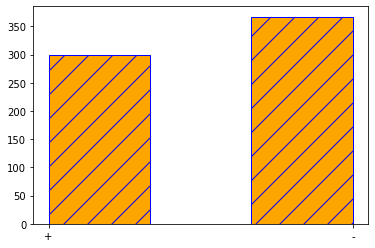

In [13]:
plt.hist(Y, bins = 3, color = 'orange', edgecolor = 'blue', hatch = '/')

In [14]:
# Binarisation de target
Y = 1 - LabelEncoder().fit_transform(Y)

In [15]:
Xnum_train, Xnum_test, Y_train, Y_test = train_test_split(Xnum, Y, train_size = 0.5, random_state = 1)
run_classifiers(clfs, Xnum_train, Y_train)

Accuracy for RF is: 0.760 +/- 0.051
AUC for RF is: 0.844 +/- 0.044
Precision for RF is: 0.769 +/- 0.099
Execution time for RF is: 0.417 +/- 0.111

Accuracy for KNN is: 0.649 +/- 0.093
AUC for KNN is: 0.697 +/- 0.095
Precision for KNN is: 0.645 +/- 0.102
Execution time for KNN is: 0.001 +/- 0.000

Accuracy for NBS is: 0.730 +/- 0.072
AUC for NBS is: 0.807 +/- 0.050
Precision for NBS is: 0.862 +/- 0.093
Execution time for NBS is: 0.001 +/- 0.000

Accuracy for CART is: 0.681 +/- 0.071
AUC for CART is: 0.684 +/- 0.072
Precision for CART is: 0.665 +/- 0.141
Execution time for CART is: 0.002 +/- 0.000

Accuracy for ID3 is: 0.699 +/- 0.079
AUC for ID3 is: 0.697 +/- 0.078
Precision for ID3 is: 0.687 +/- 0.131
Execution time for ID3 is: 0.002 +/- 0.000

Accuracy for DS is: 0.748 +/- 0.073
AUC for DS is: 0.743 +/- 0.058
Precision for DS is: 0.873 +/- 0.091
Execution time for DS is: 0.001 +/- 0.000

Accuracy for MLP is: 0.730 +/- 0.065
AUC for MLP is: 0.807 +/- 0.030
Precision for MLP is: 0.762 +

Cette fois-ci, le modèle RF semble être le meilleur.
Nous allons maintenant répéter le processus mais avec des donnés normalisées.

In [15]:
# Avec StandardScaler
Scaler = StandardScaler().fit_transform(Xnum)
Xnum_train, Xnum_test, Y_train, Y_test = train_test_split(Scaler, Y, train_size = 0.5, random_state = 1)
run_classifiers(clfs, Xnum_train, Y_train)

Accuracy for RF is: 0.760 +/- 0.051
AUC for RF is: 0.844 +/- 0.044
Precision for RF is: 0.769 +/- 0.099
Execution time for RF is: 0.419 +/- 0.008

Accuracy for KNN is: 0.721 +/- 0.045
AUC for KNN is: 0.780 +/- 0.061
Precision for KNN is: 0.767 +/- 0.142
Execution time for KNN is: 0.001 +/- 0.000

Accuracy for NBS is: 0.730 +/- 0.072
AUC for NBS is: 0.807 +/- 0.050
Precision for NBS is: 0.862 +/- 0.093
Execution time for NBS is: 0.001 +/- 0.000

Accuracy for CART is: 0.681 +/- 0.074
AUC for CART is: 0.683 +/- 0.076
Precision for CART is: 0.666 +/- 0.139
Execution time for CART is: 0.002 +/- 0.000

Accuracy for ID3 is: 0.699 +/- 0.079
AUC for ID3 is: 0.697 +/- 0.078
Precision for ID3 is: 0.687 +/- 0.131
Execution time for ID3 is: 0.002 +/- 0.000

Accuracy for DS is: 0.748 +/- 0.073
AUC for DS is: 0.743 +/- 0.058
Precision for DS is: 0.873 +/- 0.091
Execution time for DS is: 0.001 +/- 0.000

Accuracy for MLP is: 0.781 +/- 0.071
AUC for MLP is: 0.844 +/- 0.058
Precision for MLP is: 0.816 +

Le modèle MLP est le plus performant. De plus il posède une des meilleures précision.
On choisira donc ce modèle comme étant le meilleur ici.

In [16]:
# Avec MinMaxScaler
Scaler1 = MinMaxScaler().fit_transform(Xnum)
Xnum_train, Xnum_test, Y_train, Y_test = train_test_split(Scaler1, Y, train_size = 0.5, random_state = 1)
run_classifiers(clfs, Xnum_train, Y_train)

Accuracy for RF is: 0.760 +/- 0.055
AUC for RF is: 0.843 +/- 0.044
Precision for RF is: 0.771 +/- 0.104
Execution time for RF is: 0.412 +/- 0.006

Accuracy for KNN is: 0.709 +/- 0.073
AUC for KNN is: 0.744 +/- 0.077
Precision for KNN is: 0.774 +/- 0.130
Execution time for KNN is: 0.001 +/- 0.000

Accuracy for NBS is: 0.730 +/- 0.072
AUC for NBS is: 0.807 +/- 0.050
Precision for NBS is: 0.862 +/- 0.093
Execution time for NBS is: 0.001 +/- 0.000

Accuracy for CART is: 0.681 +/- 0.071
AUC for CART is: 0.684 +/- 0.072
Precision for CART is: 0.665 +/- 0.141
Execution time for CART is: 0.002 +/- 0.000

Accuracy for ID3 is: 0.696 +/- 0.080
AUC for ID3 is: 0.694 +/- 0.078
Precision for ID3 is: 0.682 +/- 0.130
Execution time for ID3 is: 0.002 +/- 0.000

Accuracy for DS is: 0.748 +/- 0.073
AUC for DS is: 0.743 +/- 0.058
Precision for DS is: 0.873 +/- 0.091
Execution time for DS is: 0.001 +/- 0.000

Accuracy for MLP is: 0.757 +/- 0.074
AUC for MLP is: 0.816 +/- 0.046
Precision for MLP is: 0.814 +

Les résultats sont très proches des résultats via StandardScaler, on ne regardera donc que StandardScaler.

De plus, la normalisation des données améliore le score du modèle. On choisira donc le modèle MLP avec données normalisées pour la suite.

In [17]:
# Question 2

In [16]:
data = pd.read_csv('./credit.data',sep='\t', header=None)

In [17]:
X = data.iloc[:, :-1].values
Y = data.iloc[:,-1].values

In [18]:
col_num = [1,2,7,10,13,14]
col_cat = [0,3,4,5,6,8,9,11,12]

In [19]:
X[:, col_cat] = OrdinalEncoder().fit_transform(X[:, col_cat])

In [20]:
Y = 1 - LabelEncoder().fit_transform(Y)
Y = Y.astype("float64")

In [21]:
# Variables catégoriques
X_cat = np.copy(X[:, col_cat]) 
for col_id in range(len(col_cat)):
     unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True)
     X_cat[:, col_id] = val_idx
imp_cat = SimpleImputer(missing_values=0, strategy='most_frequent')
X_cat[:, range(5)] = imp_cat.fit_transform(X_cat[:, range(5)])

In [22]:
# Variables numériques
X_num = np.copy(X[:, col_num])
X_num[X_num == '?'] = np.nan
X_num = X_num.astype(float)
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = imp_num.fit_transform(X_num)

In [23]:
# Traitement des variables catégoriques
X_cat_bin = OneHotEncoder().fit_transform(X_cat).toarray()

In [24]:
Scaler2 = StandardScaler().fit_transform(X_num)
Xconc = np.concatenate((X_cat_bin, Scaler2), axis = 1)

In [25]:
# Jeu de données concaténé
Xconc_train, Xconc_test, Y_train, Y_test = train_test_split(Xconc, Y, train_size = 0.5, random_state = 1)
run_classifiers(clfs, Xconc_train, Y_train)

Accuracy for RF is: 0.863 +/- 0.043
AUC for RF is: 0.930 +/- 0.039
Precision for RF is: 0.834 +/- 0.045
Execution time for RF is: 0.424 +/- 0.133

Accuracy for KNN is: 0.846 +/- 0.061
AUC for KNN is: 0.897 +/- 0.052
Precision for KNN is: 0.857 +/- 0.087
Execution time for KNN is: 0.001 +/- 0.000

Accuracy for NBS is: 0.791 +/- 0.055
AUC for NBS is: 0.896 +/- 0.036
Precision for NBS is: 0.825 +/- 0.090
Execution time for NBS is: 0.001 +/- 0.000

Accuracy for CART is: 0.814 +/- 0.046
AUC for CART is: 0.808 +/- 0.049
Precision for CART is: 0.794 +/- 0.041
Execution time for CART is: 0.002 +/- 0.000

Accuracy for ID3 is: 0.817 +/- 0.050
AUC for ID3 is: 0.813 +/- 0.048
Precision for ID3 is: 0.801 +/- 0.054
Execution time for ID3 is: 0.003 +/- 0.000

Accuracy for DS is: 0.861 +/- 0.048
AUC for DS is: 0.861 +/- 0.049
Precision for DS is: 0.802 +/- 0.055
Execution time for DS is: 0.001 +/- 0.000

Accuracy for MLP is: 0.846 +/- 0.044
AUC for MLP is: 0.901 +/- 0.045
Precision for MLP is: 0.832 +

Le modèle RF est légèrement meilleur que les autres.

# III. Apprentissage supervisé sur des données textuelles : Feature engineering et Classification

In [7]:
data2 = pd.read_table("./SMSSpamCollection.data", names = ["Target", "SMS"])
X1 = data2["SMS"]
Y1 = LabelEncoder().fit_transform(data2["Target"])

In [8]:
# Count Vectorizer
vectorizer = CountVectorizer(stop_words = "english", min_df = 0.01)
X1 = vectorizer.fit_transform(X1)

In [28]:
run_classifiers(clfs, X1.toarray(), Y1)

Accuracy for RF is: 0.969 +/- 0.007
AUC for RF is: 0.960 +/- 0.010
Precision for RF is: 0.914 +/- 0.034
Execution time for RF is: 2.329 +/- 0.130

Accuracy for KNN is: 0.949 +/- 0.010
AUC for KNN is: 0.921 +/- 0.014
Precision for KNN is: 0.976 +/- 0.016
Execution time for KNN is: 0.003 +/- 0.003

Accuracy for NBS is: 0.545 +/- 0.018
AUC for NBS is: 0.740 +/- 0.016
Precision for NBS is: 0.224 +/- 0.025
Execution time for NBS is: 0.010 +/- 0.002

Accuracy for CART is: 0.961 +/- 0.006
AUC for CART is: 0.938 +/- 0.018
Precision for CART is: 0.873 +/- 0.038
Execution time for CART is: 0.129 +/- 0.003

Accuracy for ID3 is: 0.962 +/- 0.005
AUC for ID3 is: 0.944 +/- 0.014
Precision for ID3 is: 0.882 +/- 0.033
Execution time for ID3 is: 0.121 +/- 0.002

Accuracy for DS is: 0.891 +/- 0.012
AUC for DS is: 0.599 +/- 0.022
Precision for DS is: 0.920 +/- 0.050
Execution time for DS is: 0.006 +/- 0.000

Accuracy for MLP is: 0.972 +/- 0.007
AUC for MLP is: 0.962 +/- 0.014
Precision for MLP is: 0.956 +

Nous avons plusieurs modèles avec d'excellentes performances, nous en relevons en particulier 3 :
- Le modèle RF est le plus rapide mais le moins performant des 3
- SVC et MLP sont tous deux très eprformants mais SVC est le plus rapide des deux.

In [29]:
# TfidTransformer
transformer = TfidfTransformer()
X1 = transformer.fit_transform(X1)

In [30]:
run_classifiers(clfs, X1.toarray(), Y1)

Accuracy for RF is: 0.969 +/- 0.008
AUC for RF is: 0.963 +/- 0.012
Precision for RF is: 0.932 +/- 0.036
Execution time for RF is: 2.895 +/- 0.139

Accuracy for KNN is: 0.962 +/- 0.006
AUC for KNN is: 0.934 +/- 0.012
Precision for KNN is: 0.936 +/- 0.029
Execution time for KNN is: 0.002 +/- 0.001

Accuracy for NBS is: 0.627 +/- 0.015
AUC for NBS is: 0.784 +/- 0.014
Precision for NBS is: 0.260 +/- 0.024
Execution time for NBS is: 0.008 +/- 0.002

Accuracy for CART is: 0.962 +/- 0.007
AUC for CART is: 0.925 +/- 0.020
Precision for CART is: 0.892 +/- 0.038
Execution time for CART is: 0.182 +/- 0.003

Accuracy for ID3 is: 0.960 +/- 0.007
AUC for ID3 is: 0.918 +/- 0.017
Precision for ID3 is: 0.894 +/- 0.041
Execution time for ID3 is: 0.184 +/- 0.006

Accuracy for DS is: 0.891 +/- 0.012
AUC for DS is: 0.599 +/- 0.022
Precision for DS is: 0.920 +/- 0.050
Execution time for DS is: 0.007 +/- 0.000

Accuracy for MLP is: 0.970 +/- 0.007
AUC for MLP is: 0.963 +/- 0.011
Precision for MLP is: 0.953 +

Toujours en tête le SVC, le MLP et le RF.

In [9]:
# Truncated SVD
tSVD = TruncatedSVD(n_components = 100)
X1_Svd = tSVD.fit_transform(X1)

In [10]:
run_classifiers(clfs, X1_Svd, Y1)

Accuracy for RF is: 0.968 +/- 0.006
AUC for RF is: 0.954 +/- 0.009
Precision for RF is: 0.962 +/- 0.020
Execution time for RF is: 7.151 +/- 0.143



OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.


Accuracy for KNN is: 0.955 +/- 0.011
AUC for KNN is: 0.918 +/- 0.016
Precision for KNN is: 0.968 +/- 0.026
Execution time for KNN is: 0.003 +/- 0.001

Accuracy for NBS is: 0.891 +/- 0.007
AUC for NBS is: 0.918 +/- 0.010
Precision for NBS is: 0.561 +/- 0.041
Execution time for NBS is: 0.007 +/- 0.000

Accuracy for CART is: 0.950 +/- 0.009
AUC for CART is: 0.896 +/- 0.026
Precision for CART is: 0.837 +/- 0.052
Execution time for CART is: 0.774 +/- 0.061

Accuracy for ID3 is: 0.947 +/- 0.009
AUC for ID3 is: 0.891 +/- 0.028
Precision for ID3 is: 0.822 +/- 0.036
Execution time for ID3 is: 0.582 +/- 0.029

Accuracy for DS is: 0.909 +/- 0.010
AUC for DS is: 0.766 +/- 0.026
Precision for DS is: 0.706 +/- 0.077
Execution time for DS is: 0.048 +/- 0.001

Accuracy for MLP is: 0.972 +/- 0.008
AUC for MLP is: 0.963 +/- 0.014
Precision for MLP is: 0.950 +/- 0.030
Execution time for MLP is: 10.952 +/- 1.808



KeyboardInterrupt: 

In [ ]:
Même constat que lors des deux tests précédents.

In [11]:
# Pipeline
X = data2["SMS"]
y = LabelEncoder().fit_transform(data2["Target"])

model_pipeline = Pipeline([("CountVectorizer", CountVectorizer(stop_words = "english", min_df = 0.01)),
                           ("Tfidf", TfidfTransformer()),
                           ("TruncatedSVD", TruncatedSVD()),
                           ("RandomForestClassifier()", RandomForestClassifier(n_estimators=200, random_state=1))])

model_pipeline.fit(X, y)
model_pipeline.score(X, y)

0.9843862167982771

In [12]:
X = data2["SMS"]
y = LabelEncoder().fit_transform(data2["Target"])

model_pipeline1 = Pipeline([("CountVectorizer", CountVectorizer(stop_words = "english", min_df = 0.01)),
                           ("Tfidf", TfidfTransformer()),
                           ("TruncatedSVD", TruncatedSVD()),
                           ("MLP", MLPClassifier(hidden_layer_sizes=(50, 10), random_state=1))])

model_pipeline1.fit(X, y)
model_pipeline1.score(X, y)

0.8659368269921034

In [13]:
X = data2["SMS"]
y = LabelEncoder().fit_transform(data2["Target"])

model_pipeline2 = Pipeline([("CountVectorizer", CountVectorizer(stop_words = "english", min_df = 0.01)),
                           ("Tfidf", TfidfTransformer()),
                           ("TruncatedSVD", TruncatedSVD()),
                           ("SVC", SVC())])

model_pipeline2.fit(X, y)
model_pipeline2.score(X, y)

0.8659368269921034

On regarde nos trois modèles choisis précédemment.
On remarque que le modèle RF est le meilleur, nous choisissons donc celui-là.

In [14]:
import pickle

pkl_filename = "model-pipeline.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_pipeline, file)

In [15]:
with open(pkl_filename, 'rb') as file:
    pk = pickle.load(file)

In [16]:
# Nouveau jeu de données
data3 = pd.read_csv("yelp-text-by-stars.csv", sep=';', encoding = "ISO-8859-1")

In [17]:
data3.head()

,Stars,Text
0,1,Boarded my English Mastiff here over New Year'...
1,1,Another case of the Emperor's New Clothes. So...
2,1,Came on Valentine's Day night having pre-bough...
3,1,2Nd time eating here today.1st time was great ...
4,1,Allegiant is a disaster. Their fares are chea...


In [18]:
X2 = data3["Text"].values
Y2 = data3["Stars"].values

In [19]:
for_scoring = {'f1_score': make_scorer(f1_score, average='micro'),
            'precision_score': make_scorer(precision_score, average='micro'),
            'recall_score': make_scorer(recall_score, average='micro'),
            'accuracy_score': make_scorer(accuracy_score)}

cv_scores = cross_validate(model_pipeline, X2, Y2, cv = 2, scoring = for_scoring, error_score = 'raise')

In [21]:
pk.fit(X2,Y2)

Pipeline(steps=[('CountVectorizer',
                 CountVectorizer(min_df=0.01, stop_words='english')),
                ('Tfidf', TfidfTransformer()), ('TruncatedSVD', TruncatedSVD()),
                ('RandomForestClassifier()',
                 RandomForestClassifier(n_estimators=200, random_state=1))])

In [23]:
pk.score(X2,Y2)

0.9982900930949316

In [ ]:
# Bonus

In [24]:
def longeur_max(phrase):
    max_index= 0
    for i in range(len(phrase)):
        if len(phrase[i]) >=len(phrase[max_index]):
            max_index = i
    return len(phrase[max_index])

In [25]:
longeur_max(X2)

4999

In [26]:
X_test = [x.lower() for x in X2]

for i in range(X2.size):
    X_test[i] = re.sub('[^A-Za-z]+', ' ', X_test[i])
    X_test[i] = X_test[i].split()

stop_words = stopwords.words('english')

for i in range(X2.size):
    X_test[i] = [word for word in X_test[i] if word not in stop_words]

In [27]:
vocabulary, counts = np.unique(X_test, return_counts=True)

vocabulary.shape, counts.shape

((47366,), (47366,))

In [28]:
ohe = OneHotEncoder()
transformed = ohe.fit_transform(X_test)
print(transformed.toarray())

ValueError: Expected 2D array, got 1D array instead:
array=[list(['boarded', 'english', 'mastiff', 'new', 'year', 'closed', 'sunday', 'even', 'though', 'got', 'home', 'sunday', 'leave', 'another', 'day', 'pay', 'another', 'day', 'pick', 'monday', 'morning', 'got', 'complimentary', 'bath', 'boarding', 'pick', 'got', 'car', 'noticed', 'pungent', 'musky', 'odor', 'figure', 'got', 'home', 'smell', 'bad', 'leave', 'car', 'windows', 'open', 'air', 'greenish', 'material', 'underside', 'tail', 'around', 'butt', 'tried', 'clean', 'let', 'outside', 'watery', 'diarrhea', 'called', 'asked', 'stinky', 'green', 'stuff', 'noticed', 'groomer', 'said', 'notice', 'figured', 'rolled', 'something', 'clean', 'sent', 'home', 'way', 'anal', 'gland', 'secretions', 'thinking', 'groomer', 'working', 'veterinary', 'hospital', 'recognize', 'go', 'grab', 'tech', 'somewhere', 'place', 'take', 'look', 'bring', 'poor', 'dog', 'way', 'back', 'making', 'late', 'work', 'something', 'never', 'sent', 'home', 'express', 'anal', 'glands', 'brought', 'still', 'stinky', 'leaving', 'oily', 'green', 'stuff', 'sitting', 'lobby', 'asked', 'gal', 'behind', 'counter', 'tried', 'tell', 'soap', 'asked', 'tissue', 'wiped', 'showed', 'asked', 'look', 'like', 'soap', 'would', 'like', 'tell', 'think', 'smells', 'like', 'soap', 'took', 'back', 'cleaned', 'prescribed', 'anti', 'diarrheal', 'medication', 'noticed', 'bad', 'diarrhea', 'back', 'never', 'board', 'dog'])
 list(['another', 'case', 'emperor', 'new', 'clothes', 'someone', 'artsy', 'set', 'decided', 'relatively', 'good', 'overpriced', 'fare', 'great', 'pizza', 'lemmings', 'followed', 'suit', 'anyone', 'tell', 'emperor', 'clothes', 'limited', 'hours', 'delivery', 'lack', 'dining', 'area', 'add', 'snob', 'appeal', 'taken'])
 list(['came', 'valentine', 'day', 'night', 'pre', 'bought', 'tickets', 'ended', 'waiting', 'line', 'ten', 'minutes', 'missing', 'beginning', 'movie', 'automated', 'ticketing', 'machines', 'broken', 'properly', 'staffed', 'ticket', 'counters', 'pick', 'tickets', 'already', 'bought', 'seriously', 'annoying', 'theater', 'usually', 'enjoyable'])
 ...
 list(['best', 'tom', 'yum', 'ever', 'also', 'rad', 'na', 'noodles', 'seafood', 'delicious', 'excellent', 'friendly', 'service', 'water', 'glasses', 'never', 'going', 'empty'])
 list(['best', 'groomer', 'valley', 'kind', 'wonderful', 'charlie', 'totally', 'accommodating', 'schedule', 'wonderful', 'cut'])
 list(['agree', 'reviewers', 'great', 'place', 'best', 'tools', 'particularly', 'good', 'screws', 'nuts', 'bolts', 'although', 'limited', 'selection', 'tools'])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X_test, Y2, train_size = 0.5, random_state = 1)

In [30]:
embedding_dim = 256
pad_size = 5000
vocab_size = 20000
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = pad_size))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

2023-01-03 16:33:57.481065: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-03 16:33:57.481169: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-03 16:33:57.481252: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (newtown): /proc/driver/nvidia/version does not exist


In [31]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_test, Y2,
    batch_size = 256,
    epochs=10)

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {'(<class \'list\'> containing values of types {"<class \'str\'>"})', "(<class 'list'> containing values of types set())"}), <class 'numpy.ndarray'>